# Feedforward Neural Network Regression for Depth Thermography

In [80]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
import random
%matplotlib inline

In [81]:
# Parameters for Neural Network
args = {'lr':0.01,
        'train epochs':5000,
        'noise':0.0,
        'train size':0.8,
        'train criterion':nn.L1Loss(),
        'test criterion':nn.L1Loss(),
        'scaler':RobustScaler()
        }

## Data Prepocessing

In [82]:
# read data
df = pd.read_excel('data_InSb.xlsx')

In [83]:
# layer data
y = df.filter(regex='layer')

# spectrum data
X = df.iloc[:,len(y.columns):]

In [84]:
# function to add noise as a percentage 
def add_noise(data, percentage):
    std_dev = percentage * data.std().sum()/len(data)
    noise = np.random.normal(0, std_dev, data.shape)
    noisy_data = data + noise
    return noisy_data

In [85]:
# add noise
X_noisy = add_noise(X, args['noise'])

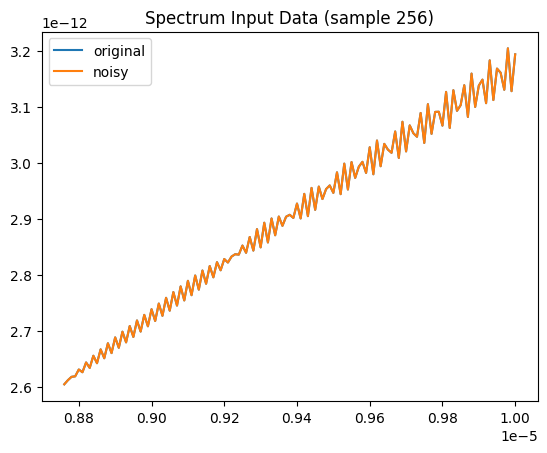

In [86]:
# plot the difference between noisy and original data
entry = random.randint(0, len(X))
plt.title(f'Spectrum Input Data (sample {entry})')
plt.plot(X.iloc[entry][-int(len(X.iloc[entry])*.25):], label='original')
plt.plot(X_noisy.iloc[entry][-int(len(X.iloc[entry])*.25):], label='noisy')
plt.legend()
plt.show()

In [87]:
# scale the input data
scaler = args['scaler']
X_noisy_scaled = scaler.fit_transform(X_noisy)

X_noisy_scaled_df = pd.DataFrame(X_noisy_scaled, columns=X.columns)

In [88]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X_noisy_scaled_df, y, train_size=args['train size'])

In [89]:
# convert data to tensors for model
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

## Neural Network Setup

In [90]:
# define neural network
class Net(nn.Module):
    def __init__(self, input_size, output_size):
        super(Net, self).__init__()
        self.lin_input = nn.Linear(input_size, 128)
        self.hidden1 = nn.Linear(128, 64)
        self.hidden2 = nn.Linear(64, 32)
        self.lin_output = nn.Linear(32, output_size)

    def forward(self, x):
        x = F.relu(self.lin_input(x))
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = self.lin_output(x)
        return x

In [91]:
# define loss function
criterion = args['train criterion']

# instantiate model
model = Net(X_train_tensor.size()[1], y_train_tensor.size()[1])

# define optimizer
optimizer = torch.optim.Rprop(model.parameters(), lr=args['lr'])

print(model)

Net(
  (lin_input): Linear(in_features=501, out_features=128, bias=True)
  (hidden1): Linear(in_features=128, out_features=64, bias=True)
  (hidden2): Linear(in_features=64, out_features=32, bias=True)
  (lin_output): Linear(in_features=32, out_features=20, bias=True)
)


## Neural Network Training Loop

In [92]:
best_loss = np.inf
best_epoch = 0
train_losses = []
valid_losses = []

print('epoch'.ljust(6) + 
      '| train loss'.ljust(14) + 
      '| valid loss' + 
      '\n------|-------------|------------')

for epoch in range(args['train epochs']):
    # forward pass
    outputs = model(X_train_tensor)

    # get loss
    loss = criterion(outputs, y_train_tensor)

    # update and backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # add losses to the list for tracking
    train_losses.append(loss.item())
    
    # check if it is the best loss
    if loss.item() < best_loss:
        best_loss = loss.item()
        best_epoch = epoch+1

    # get validation loss
    valid_pred = model(X_test_tensor)
    valid_loss = criterion(valid_pred, y_test_tensor)
    valid_losses.append(valid_loss.item())

    if (epoch+1) % int(args['train epochs']/10) == 0:
        print(f'{epoch+1}'.ljust(6) + 
              f'|   {loss:.4f}'.ljust(14) + 
              f'|   {valid_loss.item():.4f}')

print(f'\nbest training loss: {best_loss:.3f} in epoch {best_epoch}\n')  

epoch | train loss  | valid loss
------|-------------|------------
500   |   6.5979    |   6.8842
1000  |   6.5090    |   6.7778
1500  |   6.4941    |   6.7618
2000  |   6.4876    |   6.7547
2500  |   6.4745    |   6.7443
3000  |   6.4684    |   6.7410
3500  |   6.4665    |   6.7415
4000  |   6.4622    |   6.7393
4500  |   6.4591    |   6.7359
5000  |   6.4584    |   6.7353

best training loss: 6.458 in epoch 4998



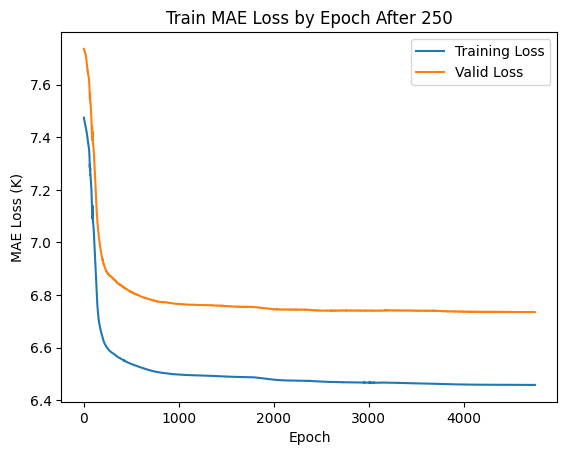

In [93]:
# plot loss over epochs
plt.plot(train_losses[250:], label='Training Loss')
plt.plot(valid_losses[250:], label='Valid Loss')

    
plt.title("Train MAE Loss by Epoch After 250")
plt.xlabel("Epoch")
plt.ylabel("MAE Loss (K)")
plt.legend()
plt.show()

## Model Testing

In [94]:
# test model on validation data
test_criterion = args['test criterion']
test_losses = []
overall_loss = 0

print('Test Losses')
with torch.no_grad():
    model.eval()

    # overall predictions and loss
    pred = model(X_test_tensor)
    loss = test_criterion(pred, y_test_tensor)

    overall_loss = loss.item()
    
    print(f'Overall: {loss.item()}\n')

    # per layer loss based on previous predictions
    pred_layers = []
    for i in range(pred.size(1)):
        column = pred[:, i]
        pred_layers.append(column)

    actual_layers = []
    for i in range(y_test_tensor.size(1)):
        column = y_test_tensor[:, i]
        actual_layers.append(column)

    for i in range(y_test_tensor.size(1)):
        loss = test_criterion(pred_layers[i], actual_layers[i])
        test_losses.append(loss.item())
        print(f'Layer {i+1}: {loss.item()}')

#print(test_losses)

Test Losses
Overall: 6.735330104827881

Layer 1: 12.824536323547363
Layer 2: 9.467391014099121
Layer 3: 9.309388160705566
Layer 4: 9.126516342163086
Layer 5: 9.410329818725586
Layer 6: 9.407276153564453
Layer 7: 9.220174789428711
Layer 8: 8.419151306152344
Layer 9: 7.821509838104248
Layer 10: 6.841094970703125
Layer 11: 6.781452178955078
Layer 12: 7.036910533905029
Layer 13: 6.595596790313721
Layer 14: 5.556802272796631
Layer 15: 3.6599555015563965
Layer 16: 4.493744373321533
Layer 17: 3.3818938732147217
Layer 18: 3.293691635131836
Layer 19: 1.689566969871521
Layer 20: 0.36961081624031067


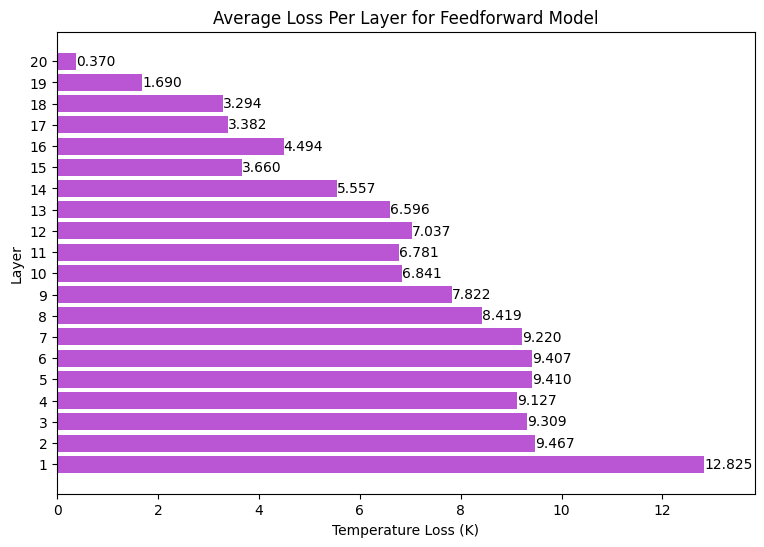

In [95]:
# plot losses
plt.figure(figsize=(9,6))
plt.title('Average Loss Per Layer for Feedforward Model')
plt.barh(range(1,len(y.columns)+1), test_losses, color='mediumorchid')
plt.yticks(range(1,len(y.columns)+1))
plt.xlabel("Temperature Loss (K)")
plt.ylabel("Layer")
plt.xlim(0,max(test_losses)+1)

for i, loss in enumerate(test_losses):
    plt.text(loss, i + 1, f'{loss:.3f}', ha='left', va='center')

plt.show()

## Prediction Visualization

In [96]:
# put predictions into dataframe for comparison
pred_df = pd.DataFrame(pred.numpy())

In [97]:
# function to plot comparison between predicted and actual values from a given sample
def plot_comparison(pred, actual, sample):
    plt.figure(figsize=(12, 6))
    plt.title(f"Feedforward Temperature Predictions for Sample {sample}", fontsize=20)
    plt.xlabel("Material Layer", fontsize=18)
    plt.ylabel("Temperature (K)", fontsize=18)
    plt.plot([i+1 for i in range(len(y_test.columns))], actual, color='darkgray', marker='s', label='actual')
    plt.plot([i+1 for i in range(len(y_test.columns))], pred, color='mediumorchid', marker='o', linestyle=' ', label='predicted')
    plt.xticks(range(1,len(y.columns)+1), fontsize=16)
    plt.yticks(fontsize=16)
    plt.ylim(285, 350)
    
    #for i in range(len(pred)):
    #    diff = abs(pred[i] - actual[i])
    #    plt.text(i+1, pred[i] + 2, f"{diff:.2f}", fontsize=16, horizontalalignment='center', verticalalignment='center')
        
    plt.legend()
    plt.show()

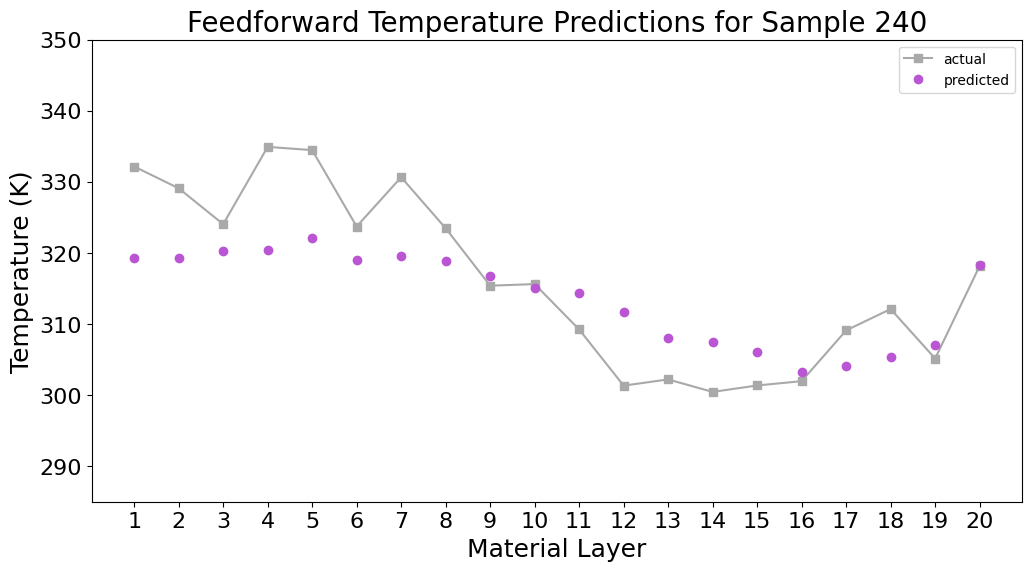

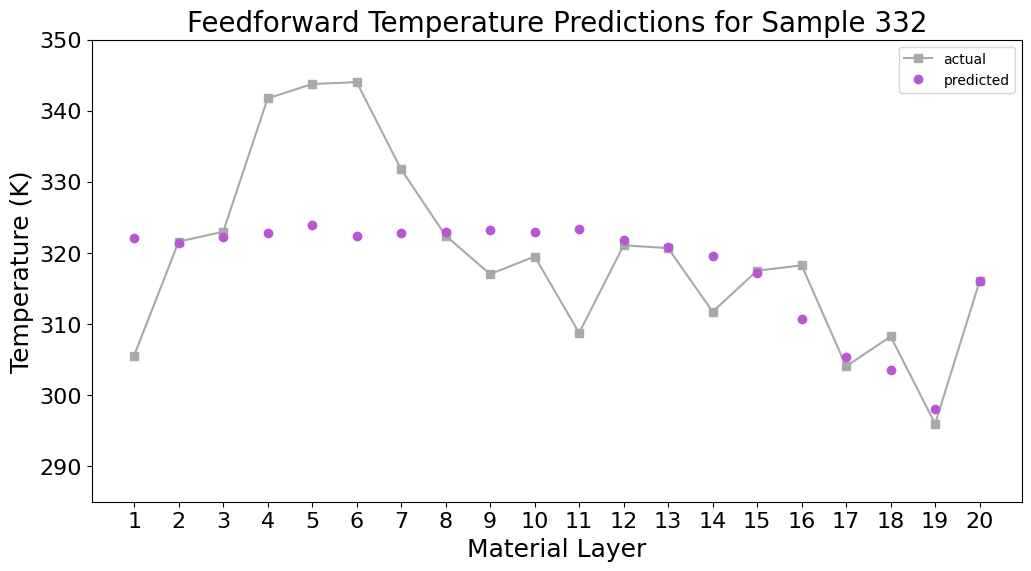

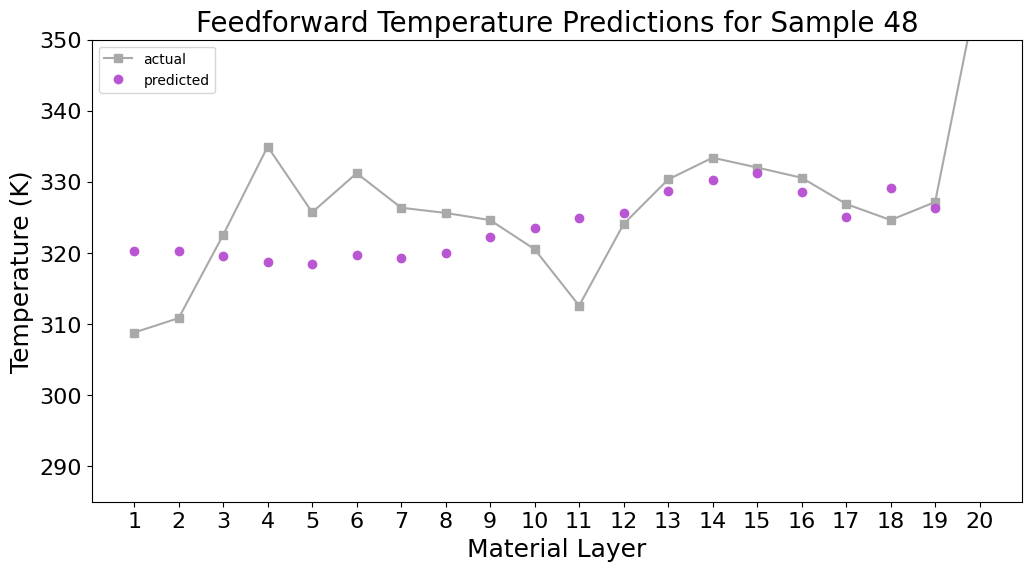

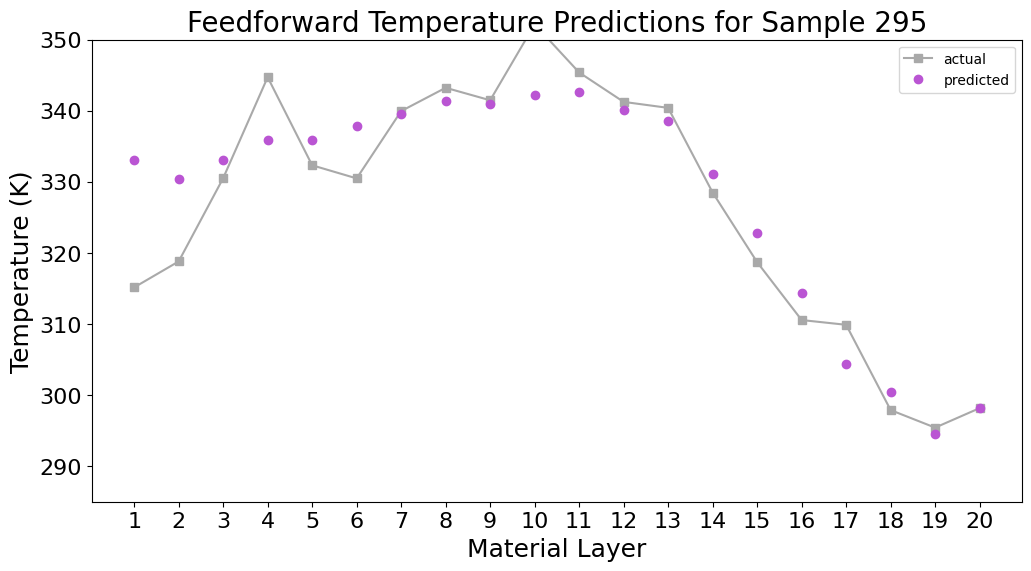

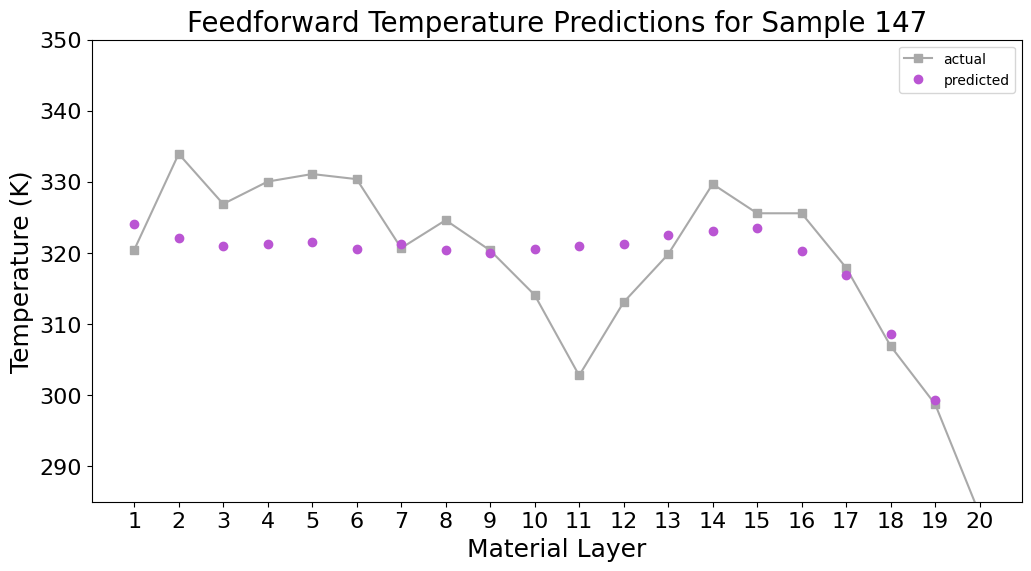

In [98]:
# pick 5 random indices from the dataset and plot the comparison between predicted and actual values
indices = []
for i in range(0,5):
    n = random.randint(0, len(y_test))
    indices.append(n)

for i in indices:
    a = y_test.iloc[i,:]
    p = pred_df.iloc[i,:]

    plot_comparison(p, a, i)

In [99]:
loss_dif = np.inf
closest = 0
closest_loss = 0

for i in range(len(X_test)):
    x_row = X_test_tensor[i]
    y_row = y_test_tensor[i]

    pred = model(x_row)
    loss = test_criterion(pred, y_row)

    dif = abs(loss.item() - overall_loss)
    if dif < loss_dif:
        loss_dif = dif
        closest = i
        closest_loss = loss.item()

print(closest_loss)


6.7345685958862305


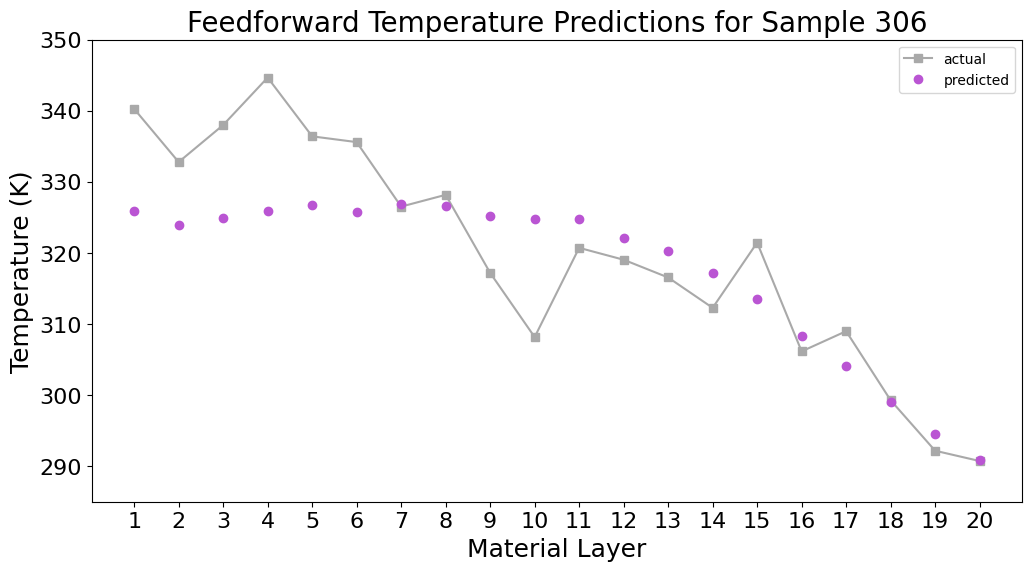

In [100]:
a = y_test.iloc[closest,:]
p = pred_df.iloc[closest,:]

plot_comparison(p, a, closest)

In [101]:
'''with open('simple_net_results.txt', 'a') as file:
    file.write(f'{overall_loss}\n')
    file.write(f'{test_losses}\n\n')'''

"with open('simple_net_results.txt', 'a') as file:\n    file.write(f'{overall_loss}\n')\n    file.write(f'{test_losses}\n\n')"